In [1]:
# 导入相关包
import random
import decimal
import numpy as np
import networkx as nx
from matplotlib import cm
import math
import matplotlib.pyplot as plt
from decimal import Decimal
from scipy.optimize import minimize
 
# mind quantum里面的包
import mindspore as ms
import mindspore.nn as nn
from mindspore import Tensor,Parameter
from mindspore import dtype as mstype                                                                                                                                  
from mindquantum.simulator import Simulator 
from mindquantum.core.operators import QubitOperator  # 引入稀疏算子定义模块
from mindquantum.core.gates import X, Y, Z, H, RX, RY, RZ, Measure  # 导入量子门H, X, Y, Z, RX, RY, RZ
from mindquantum.core.circuit import Circuit 
from mindquantum.core.gates import  Measure # 导入相关的量子门以及量子测量（用于电路采样)
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz  
 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# 创建p层ansatz电路，直接调用HardwareEffiecient ansatz
# 搭建含参酉电路U（lamada），制备量子态phi(lanmada) = U(lamada)|0>
def create_ansatz_circuit(n,layer):
    ansatz_p = HardwareEfficientAnsatz(n, single_rot_gate_seq=[RY], entangle_gate=X, depth=layer).circuit     # 通过HardwareEfficientAnsatz搭建Ansatz
    ansatz_p.as_ansatz()
    return  ansatz_p
 
 

 
# 参数：一维数组 ansatz_data，为含参酉电路赋值；
# 功能：获取ψ(λ)中的测量结果；
# 返回：字典info，存储十进制k和系数ψ_k之间的对应关系；
 
def get_info_state(n,layer,ansatz_data): 
    # 获取制备量子态的含参酉电路
    ansatz= create_ansatz_circuit(n,layer)
 
 
    # 量子模拟器
    sim = Simulator('projectq', n)
 
    
    # 参数赋值
    pr = {}
   
    # ansatz_data
    for i in range(0,len(ansatz.params_name)):
        pr[ansatz.params_name[i]] = ansatz_data[i]
 
    
    
    # 查看当前量子态，result是一个一维数组类型，result内存储每个量子态的系数phi_k
    sim.apply_circuit(ansatz,pr=pr)
    result = sim.get_qs()
    
    # 文献[1]内已说明f(x)是一个实值函数，phi_k = math.sqrt(h_N)*f_k，因此phi_k也是实值的
    result = np.real(result)
 
   
    # 数据类型转化，数组转为列表，列表result内依次存储phi_k信息
    result = result.tolist()
 
    
    # 将信息存储到字典info内，info = {'十进制k':phi_k}
    info = {}
    for k in range(0,len(result)):
        info[k] = result[k]
        
#     print('利用get_qs()查看当前量子态，键值对分别为k和phi_k,info = {}'.format(info))
 
    return info
 

In [3]:
# 获取x_k 和V（x_k）之间的对应关系
def get_info_V():
   
    k2 = (2*k1)/(1+math.sqrt(5))
    N = 2**n
    h_N = (b-a)/N
 
    # 计算每个x_k对应的V（x_k）
    result = {}
    for k in range(0,2**n):
        x_k  = a + k*h_N
        
        # 函数V（x）
        V = s1*(math.sin(k1*x_k))+ s2*(math.sin(k2*x_k))
        
        # 键值对形式存储,存储十进制k和函数V（x_k）之间的对应关系
        result[k] = V
    return result
 
 

 
# 计算Interaction energy
def calculate_I(n,layer,ansatz_data,info):
   
    # 计算并存储每一个x_k对应的phi(k)的四次方
    result_I = 0
    for key,value in info.items():
        result_I += value**4
 
        
    # 系数不能忘，
    result_I = 0.5*g*(2**n)*result_I/(b-a)
 
    return result_I
 
 

 
# 计算Kinetic energy
def calculate_K(n,layer,ansatz_data,info):
    
    result_K = 0
    
    # 字典info = {k：phi_k}
    # 读取phi(k),phi(k+1)以及phi(k-1)
    for k in range(0,2**n):
        if k == 0:
            # 此时phi_(-1) = phi_(N-1)
            result_K  += info[k]*(info[k+1]-2*info[k]+info[(2**n)-1])    
            
        if k > 0 and k < ((2**n)-1):
            result_K  += info[k]*(info[k+1]-2*info[k]+info[k-1])
            
        if k == ((2**n)-1):
            # phi_N = phi_0,boundary condition
            result_K  += info[k]*(info[0]-2*info[k]+info[k-1])
            
        
    # 系数不能忘,h_N = (b-a)/N
    N = 2**n
    # 区间间隔
    l = b-a
    result_K = (-0.5*result_K)*(N**2)/(l**2)
 
    return  result_K
    
 
 

# 计算Potential energy
def calculate_P(n,layer,ansatz_data,info):
    # 获取x_k以及V（x_k）之间的对应关系，result为字典，result = {'十进制k':V(x_k)}
    result = get_info_V()
    
    # 计算phi_k*V（x_k）*phi_k，通过k实现相关计算,结果存储在result_P中
    result_P = 0
    
    for k,value in info.items():
        result_P += value*result[k]*value
    
 
    return result_P       
 
 
 
# 参数：layer是当前ansatz层数
# 功能：利用有限差分法计算梯度，存储在列表gradient内
# 返回：列表gradient以及在ansatz_data下的函数值function_value
 
def calculate_gradient(n,layer,ansatz_data):
    print('ansatz_data = {}'.format(ansatz_data))
    
    # 梯度信息存储到列表gradient中
    gradient = []
    
    # 获取当前ansatz_data下的代价函数值
    result_K,result_P,result_I,function_value = cost_function(n,layer,ansatz_data)
    
    
    # 输出当前ansatz_data下的能量值
    print('result_K = {}, result_P = {},result_I = {},function_value = {}'.format(result_K,result_P,result_I,function_value))   
    print('\n')
    
    m = len(ansatz_data)
    # 有限差分法,这个delta可以看作是一个超参数，太小，算出的梯度为0，太大，有限差分法算出的梯度和实际梯度之间的误差会很大，会报错
    # 所以跑代码的过程中要结合比特数n的大小来调整这个delta，
    delta = 1e-6
    
    for i in range(0,m):
        data = ansatz_data.copy()
        data[i] = data[i] + delta
        
        # 获取代价函数值
        result_K,result_P,result_I,function_value1 = cost_function(n,layer,data)
        
        gap = function_value1 - function_value
        gradient.append(gap/delta)
    print('gradient = {}'.format(gradient))
    print('\n')
        
    # 以列表形式返回梯度信息
    return function_value, gradient   


In [4]:
# 计算当前参数对应的量子态phi_lamada对应的函数值
def cost_function(n,layer,ansatz_data):
    
    # 列表转为数组，一维数组
    ansatz_data = np.array(ansatz_data).astype(np.float32)
 
   
    # 获取测量结果,info = {'十进制k':phi_k}
    info = get_info_state(n,layer,ansatz_data)
    
    # 获取K、P、I的数值
    result_K = calculate_K(n,layer,ansatz_data,info)
    result_P = calculate_P(n,layer,ansatz_data,info)
    result_I = calculate_I(n,layer,ansatz_data,info)
    
    function_value = result_K + result_P + result_I
   
    return result_K, result_P, result_I,function_value
 
 

 
def get_expectation(n,layer,ansatz_data):
    def execute_circ(ansatz_data):
        return calculate_gradient(n,layer,ansatz_data)
    return execute_circ

In [5]:
# 方式1：全局优化策略
# 参数：量子比特数n以及ansatz总层数p
# 功能：一次性搭建p层ansatz电路，并且实现参数随机初始化、调用scipy内的minimize函数进行参数优化， 
# 返回：迭代停止时的参数ansatz_data
def global_training(n,p):
    # ansatz_data初始化
    initial_ansatz = []
    m  = len(ansatz.params_name)
    for i in range(0,m):
        parameter= random.random()
        parameter = parameter*3.14
        # 保留小数点之后五位，四舍五入
        parameter = Decimal(parameter).quantize(Decimal("0.00001"), rounding = "ROUND_HALF_UP")
        initial_ansatz.append(float(parameter))
 
    # 类型转换,列表转换为一维数组
    initial_ansatz = np.array(initial_ansatz).astype(np.float32)
    print('\n')
    print('p = {},initial_ansatz = {}'.format(p,initial_ansatz)) 
    print('\n\n')
 
 
    # 最小化代价函数
    out = minimize(fun = get_expectation(n,p,initial_ansatz),x0 = initial_ansatz, method="BFGS",jac = True, options={'eps':1e-02,'return_all':True,'disp':True,'maxiter':1000}) 
    print(out)
 
    # 获取优化后的参数，存储到ansatz_data
    ansatz_data = out['x']
    
    # 返回迭代停止时的参数信息
    return ansatz_data

In [6]:
# 参数：layer即ansatz的层数，counts为参数优化重复的次数（可见说明文档，里面有关于Fixing strategy策略实现的详细说明）
# 功能：实现前layer-1层参数的赋值以及第layer层参数的随机初始化，利用scipy内minimize函数实现全体参数的优化
# 返回：电路为layer层，代价函数收敛时对应的的参数ansatz_data以及function_value
def train_parameters(layer,counts,ansatz_data):
   # 记录深度为layer时，优化后函数值和优化后参数之间的对应关系
    info = {}
    # 记录优化后的函数值
    loss = []
    for times in range(1,counts+1):
        # 电路层数为layer时，ansatz_data参数的初始化
        if layer == 1:
            initial_ansatz = []
            for i in range(0,(layer + 1)*n):
                parameter= random.random()
                parameter = parameter*3.14
                # 保留小数点之后五位，四舍五入
                parameter = Decimal(parameter).quantize(Decimal("0.00001"), rounding = "ROUND_HALF_UP")
                initial_ansatz.append(float(parameter))
 
        else:
            # 前layer-1层的ansatz_data
            initial_ansatz = ansatz_data[:]
            # 添加第layer层的ansatz_data
            for i in range(0,n):
                parameter= random.random()
                parameter = parameter*3.14
                # 保留小数点之后五位，四舍五入
                parameter = Decimal(parameter).quantize(Decimal("0.00001"), rounding = "ROUND_HALF_UP")
                initial_ansatz.append(float(parameter))
                    
        # 类型转换,列表转换为一维数组
        initial_ansatz = np.array(initial_ansatz).astype(np.float32)
        print('\n\n')
        print('第{}次随机初始化,layer = {},initial_ansatz = {}'.format(times,layer,initial_ansatz)) 
 
        # 参数优化部分
        out = minimize(fun = get_expectation(n,layer,initial_ansatz),x0 = initial_ansatz, method="BFGS",jac = True, options={'eps':1e-02,'return_all':True,'disp':True,'maxiter':1000}) 
        print(out)
        
        # 记录优化后参数以及优化结果之间的对应关系，out['x']为优化后的参数，out['fun']为优化后的函数值
        out_ansatz = out['x']
        # 对应关系存储在字典info内
        info[out['fun']] = out_ansatz
 
        # 存储优化后的代价函数值
        loss.append(out['fun'])
   
    # 输出counts组随机初始化参数，优化后对应的函数值      
    # 保留最小函数值对应的参数，当depth = layer+1时，作为前layer层的初始化参数
    min_loss = min(loss)
    ansatz_data = info[min_loss]
    print('layer = {}，loss = {},min_loss = {},最小函数值对应优化后的ansatz_data = {}'.format(layer,loss,min_loss,ansatz_data))
    print('\n')
    
    return ansatz_data,min_loss
  
# 方式2： Fixing strategy
# 功能：逐层搭建ansatz电路，直至电路层数为p，同时实现参数优化
# 返回：电路为p层时，代价函数收敛时对应的参数ansatz_data以及function_value
def layerwise_training(n,p):  
    # 根据层数确定有counts次随机初始化参数以及counts次参数训练的过程，并将每次优化结果存储在loss中
    counts = 3
    
    
    current_data = []
    for i in range(2,p+2): 
        data, min_loss = train_parameters(i-1,counts,current_data)
        
        # 更新参数信息
        ansatz_data = []
        for k in range(0,len(data)):
            ansatz_data.append(data[k])
        current_data = ansatz_data[:]
       
            
 
   # 电路共p层，优化得到的min_loss对应的参数存储在列表data中    
    
    return data, min_loss

In [7]:
n = int(input('请输入量子比特数个数：'))
p = int(input('请输入ansatz层数：'))
 
# 相关系数均按照论文里给定的取值
# 非线性强度
g = 50
# 区间[a,b]定义为[0,1]
a = 0
b = 1
 
k1 = 32
k1 = 2*3.1415*k1
 
s1 = 20000
s2 = 100


# 电路图可视化，n为量子比特数，p是ansatz层数
ansatz= create_ansatz_circuit(n,p)
print('含参酉电路搭建如下：')
ansatz.svg()

请输入量子比特数个数：3
请输入ansatz层数：4
含参酉电路搭建如下：


In [8]:
# 获取f(x_k)*f(x_k)和x_k的数值变化关系
x = []
f = {}
for i in range(0,2**n):
    x_k  = a + (i*(b-a)/(2**n))
    x.append(x_k)

In [9]:
# 获取优化后的参数信息
# 策略1：全局
ansatz_data = global_training(n,p)



# 策略2：Fixing strategy,策略2只是提供了另一种思路，我们希望它可以获得更好的数值结果，但是通过实际优化效果来看和重复counts次策略1效果相差不大
# 感兴趣的可以看一下这部分，不感兴趣的自行绕过即可
# ansatz_data,min_loss = layerwise_training(n,p)
# print(ansatz_data,min_loss)
 
# ansatz_data = np.array(ansatz_data).astype(np.float32)
# print('优化得到的ansatz_data = {}'.format(ansatz_data))
# print('\n')



p = 4,initial_ansatz = [0.64935 1.49338 2.12218 3.13214 0.81082 2.72526 1.11647 0.14662 2.80197
 2.70899 1.07052 0.41312 0.86931 1.14521 3.09569]



ansatz_data = [0.64934999 1.49337995 2.12217999 3.13213992 0.81081998 2.72526002
 1.11646998 0.14662001 2.80197001 2.7089901  1.07052004 0.41312
 0.86931002 1.14521003 3.09569001]
result_K = 52.061096144062574, result_P = -19.673403948615146,result_I = 53.45910466162793,function_value = 85.84679685707536


gradient = [67.64136513481844, 1.3546560069244151, -3.7631214127031853, 67.01631971850475, -10.415941829933217, 25.264843230843326, 71.95415335559119, -2.2603856848490977, -13.890964339680067, -84.35231595171899, 2.707404831880922, 39.505463377054184, 64.6079722059767, -5.051920396681453, -21.778910110015204]


ansatz_data = [0.24511104 1.48528424 2.14466919 2.73163638 0.87306783 2.57427203
 0.68645691 0.16012854 2.88498531 3.21309718 1.05434003 0.17702709
 0.48319927 1.17540136 3.22584533]
result_K = 37.1712317980181, result_P = -81.5

the info of phi_k is {0: 0.27824370522936676, 1: 0.2674067867507243, 2: 0.32294929625519503, 3: -0.08188947674780489, 4: -0.4487826678131765, 5: 0.11860554364948903, 6: 0.6308871690349201, 7: 0.35578102616543816}


the info of f(x_k) is {0: 0.7869920431606242, 1: 0.7563406089869688, 2: 0.9134385494458868, 3: -0.23161841726476376, 4: -1.2693490707587474, 5: 0.33546713680348295, 6: 1.7844183815527026, 7: 1.0063007048763593}


Text(0.5, 0, 'x_k')

Text(0, 0.5, 'f(x_k)*f(x_k)')

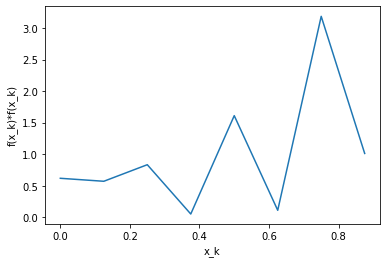

In [10]:
# 根据优化后的参数信息，获取info = {'k':phi_k}，k为十进制数
info = get_info_state(n,p,ansatz_data)
print('the info of phi_k is {}'.format(info))
print('\n')
 
# 将info内的键值对由info = {'k':phi_k}转换为info = {'k':f_k}
N = 2**n
h_N = (b-a)/N
for key,value in info.items():
    info[key] = value/math.sqrt(h_N)
print('the info of f(x_k) is {}'.format(info))
    
# 计算每一个f(x_k)的平方,存储在列表f中
f = []
for k,value in info.items():
    f.append(value**2)
    
# 绘制x_k和f(x_k)平方的数值关系
# 生成柱状图
# plt.bar(x,f,0.5,color="blue")
plt.plot(x,f)
plt.xlabel('x_k')  # x轴标题
plt.ylabel('f(x_k)*f(x_k)')  # y轴标题

In [11]:
# 迭代停止，对应参数信息
ansatz = create_ansatz_circuit(n,p)
ansatz_names = ansatz.params_name                     # Ansatz中所有参数组成的数组，ansatz.para_name系统会自动生成
print('ansatz_names =', ansatz.params_name)
print('\n')
 
# 获取ansatz_data输出，合并到encoder_data数据中
pr1 = dict(zip(ansatz.params_name, ansatz_data)) # 获取线路参数
 
# 向字典pr中添加参数信息，获取ansatz_data的完整信息
pr = {}
for key,value in pr1.items():
    pr[key] = value
print('优化后的参数信息：{}'.format(pr))  
print('\n\n')
 
# 训练结束，采样
ansatz.measure_all()
# 量子模拟器
sim = Simulator('projectq', n) 
result = sim.sampling(ansatz,pr =pr,shots=1000)  # 对上面定义的线路采样1000次
print(result.data)
result.svg()

ansatz_names = ['d0_n0_0', 'd0_n1_0', 'd0_n2_0', 'd1_n0_0', 'd1_n1_0', 'd1_n2_0', 'd2_n0_0', 'd2_n1_0', 'd2_n2_0', 'd3_n0_0', 'd3_n1_0', 'd3_n2_0', 'd4_n0_0', 'd4_n1_0', 'd4_n2_0']


优化后的参数信息：{'d0_n0_0': 0.3512939835282872, 'd0_n1_0': 2.7414794967256344, 'd0_n2_0': 2.315898234455582, 'd1_n0_0': 2.6831777507982992, 'd1_n1_0': 0.8350300994218868, 'd1_n2_0': 1.6432521572069796, 'd2_n0_0': 0.3981520585866264, 'd2_n1_0': 0.898835108279694, 'd2_n2_0': 3.652618018369967, 'd3_n0_0': 3.0827772395710538, 'd3_n1_0': 1.1206416895015605, 'd3_n2_0': -0.0835301231114584, 'd4_n0_0': 0.42719280288871847, 'd4_n1_0': 1.3758601784751299, 'd4_n2_0': 2.8650608715442862}





q0: ──RY(d0_n0_0)────●────RY(d1_n0_0)───────────────────●────RY(d2_n0_0)───────────────────●────RY(d3_n0_0)───────────────────●────RY(d4_n0_0)───────M(q0)──────────────
                     │                                  │                                  │                                  │
q1: ──RY(d0_n1_0)────X─────────●─────────RY(d1_n1_0)────X─────────●─────────RY(d2_n1_0)────X─────────●─────────RY(d3_n1_0)────X─────────●─────────RY(d4_n1_0)────M(q1)──
                               │                                  │                                  │                                  │
q2: ──RY(d0_n2_0)──────────────X─────────RY(d1_n2_0)──────────────X─────────RY(d2_n2_0)──────────────X─────────RY(d3_n2_0)──────────────X─────────RY(d4_n2_0)────M(q2)──

{'000': 76, '001': 69, '010': 100, '011': 15, '100': 223, '101': 10, '110': 386, '111': 121}
